The goal of this project is to apply acoustic beamforming to locate the source of a sound

We will work in a sumilated environment


In [36]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import PIL
from progressbar import progressbar


In [37]:
CENTER_MICROPHONE = np.array([0.0, 0.0, 0.0])
TARGET_GRID_CENTER = np.array([0.0, 0.0, 5.0])
IMAGE_DIM = (30, 30)
scan_plane_size = (8.0, 8.0)

SAMPLE_RATE = 22050
SAMPLE_DURATION = 0.2
violin = librosa.load('audio/violin_c.wav')[0]
white_noise = librosa.load('audio/noise.wav')[0]
hz440 = librosa.load('audio/sine_440.wav')[0]
hz1000 = librosa.load('audio/sine_1000.mp3')[0]


test_points = []
for i in range(-int(IMAGE_DIM[1] / 2), int((IMAGE_DIM[1] + 1) / 2)):
    for j in range(-int(IMAGE_DIM[0] / 2), int((IMAGE_DIM[0] + 1) / 2)):
        test_points.append(TARGET_GRID_CENTER + np.array([
            scan_plane_size[0] / (IMAGE_DIM[0] - 1) * j,
            scan_plane_size[1] / (IMAGE_DIM[1] - 1) * i,
            0.0
        ]))

def hermite(a):
    return np.conj(np.transpose(a))


The array of microphones consists in a grid of uniformly spaced microphones.

In [38]:

def get_microphone_potitions(mic_array_dim, mic_spacing):
    microphone_positions = []
    for i in range(mic_array_dim[0]):
        for j in range(mic_array_dim[1]):
            microphone_positions.append(CENTER_MICROPHONE + np.array([
                (j - np.floor(mic_array_dim[0] / 2)) * mic_spacing[0],
                (i - np.floor(mic_array_dim[1] / 2)) * mic_spacing[1],
                0.0
            ]))
    return microphone_positions




The sound pressure recorded at time $t$ by a microphone located at position $x$ produced by a source in $x_0$ is:

$\begin{equation} \tag 1
p(x, x_0, t) = \frac{1}{4\pi} \frac{q(x_0, t-t_0)}{\lvert x - x_0 \rvert}
\end{equation}$

where $t_0$ is the time sound waves take to travel from $x$ to $x_0$

$\begin{equation} \tag 2
t_0 = \frac{\lvert x - x_0 \rvert}{c_0}
\end{equation}$

and $c_0$ is the speed of sound.

In [39]:
SOUND_SPEED = 343  # m/s
def get_delay(a, b):
    return np.linalg.norm(a - b) / SOUND_SPEED


def get_recorded_sound(sources, mic_pos, start_time, sample_length):
    start_index = int(start_time * SAMPLE_RATE)
    sounds = []
    for source_position, track in sources:
        time_delay = get_delay(TARGET_GRID_CENTER + np.append(source_position, 0.0), mic_pos)
        index_delay = int(time_delay * SAMPLE_RATE)
        sounds.append(track[start_index + index_delay:start_index + index_delay + sample_length])
    received_sound = sum(sounds)
    return received_sound


# Beamforming
The first step in the analysis is to beamform over the points we are interested in.

##  Delay and sum beamforming

This approach consists in anticipating the signal recorded by each microphone by the time sound would take to reach it from the point of the searching grid we are testing.

The shifted signals are then summed and the result is divided by the number of microphones in the array. In this way if the sound source corresponds to the point we are testing the waves will generate constructive interference producing an amplified output, otherwise the phase mismatch will cancel the signals and result in a low amplitude output. 

The output of the beamformer is expressed as:

$\begin{equation} \tag 3
Z(t, x_0) = \frac{4\pi}{M} \sum_{m=1}^M \lvert x - x_0 \rvert p_m(x_0, t + t_0)
\end{equation}$

where $p_m$ if the pressure measured by microphone $m$, $M$ is the number of microphones, $x_0$ is the test position and $x$ is the microphone position.

Time domain formulation is simple and computationally fast, but it doesn't allow for post processing deconvolution techniques, for this reason we will use the frequency domain formulation.

## Frequency domain formulation
The first step of this approach is to compute the fourier transform of the signals received by the microphones:

$\begin{equation} \tag 4
P_m(x, x_0, \omega) = \mathscr{F}\{p(x, x_0, t)\} = \frac{Q(\omega)e^{-i \omega t_0}}{4\pi \lvert x - x_0 \rvert}
\end{equation}$

The output of the beamformer is now

$\begin{equation} \tag 5
Z(\omega, x_0) = \frac{4\pi}{M} \sum_{m=1}^M \lvert x - x_0 \rvert P(x, x_0, \omega) e^{i \omega t_0}
\end{equation}$

where

$\begin{equation} \tag 6
s(x, x_0, \omega) = 4\pi \lvert x - x_0 \rvert e^{-i \omega t_0}
\end{equation}$

is called the steering function.


In [40]:
def get_spectrums(sources, microphone_positions, start_time=0.0):
    sample_length = int(SAMPLE_DURATION * SAMPLE_RATE)
    spectrums = []
    for mic_pos in microphone_positions:
        recorded_sound = get_recorded_sound(sources, mic_pos, start_time, sample_length)
        spectrum = np.fft.fft(recorded_sound) / (4 * np.pi * np.linalg.norm(mic_pos - TARGET_GRID_CENTER))
        spectrums.append(spectrum)
    return spectrums


Given a point in the searching grid $x_0$ there is a steering function for each microphone, which are usually summarized in the steering vector


$\begin{equation} \tag 7
  g(x, \omega) =
  \left(
    \begin{aligned}
      & 4\pi \lvert x_1 - x_0 \rvert e^{-i \omega t_1} \\
      & 4\pi \lvert x_2 - x_0 \rvert e^{-i \omega t_2} \\
	  & \;\;\;\;\;\;\;\;\;\;\;\;\;\vdots \notag \\
	  & 4\pi \lvert x_M - x_0 \rvert e^{-i \omega t_M}
    \end{aligned}
  \right)
\end{equation}$

The calculations become more convenient if the vector is normalized by the distance between the source and the center of the microphone array, so the normalilzed steering vector is defined as

$\begin{equation} \tag 8
\hat{e}(x, \omega) = \frac{g(x, \omega)}{\lvert x_c - x_0 \rvert}
\end{equation}$

The fourier transform of the microphone array can also be represented in vector form

$\begin{equation} \tag 9
\hat{P}(\omega) = 
\left(
    \begin{aligned}
	& P_1(\omega) \\
	& P_2(\omega) \\
	& \;\;\;\;\;\vdots \notag \\
	& P_M(\omega)
    \end{aligned}
  \right)
\end{equation}$

In order to make numpy computations faster the steering vectors are grouped into an array that contains one steering vector for each point in the search grid.


In [41]:
def get_steering_vector_component(mic_pos, test_pos, frequency):
    distance = np.linalg.norm(mic_pos - test_pos)
    delay = get_delay(test_pos, mic_pos)
    omega = 2 * np.pi * frequency
    return 4 * np.pi * distance * np.exp(-1j * omega * delay)

def get_steering_vector(test_point, microphone_positions, freq):
    steering_vector = np.array(
        [
            get_steering_vector_component(mic_pos, test_point, freq)
            for mic_pos in microphone_positions
        ]) / np.linalg.norm(test_point - CENTER_MICROPHONE)
    return steering_vector.reshape(len(microphone_positions), 1)

def get_steering_vectors(test_points, microphone_positions, freq):
    steering_vectors = np.zeros((len(test_points), len(microphone_positions)), dtype=np.complex_)
    for i, test_point in enumerate(test_points):
        steering_vector = get_steering_vector(test_point, microphone_positions, freq)
        steering_vectors[i] = steering_vector.reshape((len(microphone_positions)))
    return steering_vectors.reshape(len(test_points), len(microphone_positions), 1)


The output of the beamformer can then be written as the dot product between the steering vector conjugate and the microphone array response:

$\begin{equation} \tag {10}
Z(\omega) = \frac{\hat{e}(x, \omega)^\dag \hat{P}(\omega)}{M}
\end{equation}$

We are interested in the power output of the beamformer, so

$\begin{equation} \tag {11}
L(x) = ZZ^* = \frac{\hat{e}^\dag(\hat{P}\hat{P}^\dag)\hat{e}}{M^2}
\end{equation}$

The term in parenthesis is called the Cross Spectral Matrix

$\begin{equation} \tag {12}
CSM(\omega) = \hat{P}(\omega)\hat{P}(\omega)^\dag =
\begin{bmatrix} 
P_1P_1^*           & \dots         & P_1P_M^*         \\ 
\vdots   &  \ddots    & \vdots \\
P_MP_1^*           & \dots         & P_MP_M^*         \\
\end{bmatrix}
\end{equation}$


The steering vectors and the CSM are only computed for the frequency we want to look for. The components of the spectrums we are interested in are extracted from the ```spectrums``` array and put in the ```freq_intensisies``` vector, which is used to compute the Cross Spectral Matrix.

In [42]:
def get_frequency_intensities(frequency, spectrums):
    test_freq_index = int(frequency * SAMPLE_DURATION)
    frequency_intensities = np.array([spectrum[test_freq_index] for spectrum in spectrums]).reshape(len(spectrums), 1)
    return frequency_intensities

def get_csm(frequency_intensities):
    return frequency_intensities @ np.conj(np.transpose(frequency_intensities))

def get_beamformer_output_power(steering_vectors, csm):
    mat = np.zeros((len(steering_vectors)), dtype=np.complex_)
    mic_count = len(csm)
    for i, steering_vector in enumerate(steering_vectors):
        mat[i] = np.take(hermite(steering_vector) @ csm @ steering_vector, 0) / mic_count**2
    return mat


This is an example that shows how to get the beamformer power output when a sound source of $1kHz$ is positioned at coordinates $(2.0m, 2.0m)$ on the searching grid.

In [43]:
mic_array_dim = (5, 5)
mic_spacing = (0.3, 0.3)

microphone_positions = get_microphone_potitions(mic_array_dim, mic_spacing)

sources = [
    (np.array([2.0, 2.0]), hz1000)
]

test_freq = 1000

spectrums_1_source = get_spectrums(sources, microphone_positions)
frequency_intensities = get_frequency_intensities(test_freq, spectrums_1_source)
csm = get_csm(frequency_intensities)
steering_vectors = get_steering_vectors(test_points, microphone_positions, test_freq)
bop_1_source = get_beamformer_output_power(steering_vectors, csm)


We now need to show the ```beamformer_output_array``` in an image.

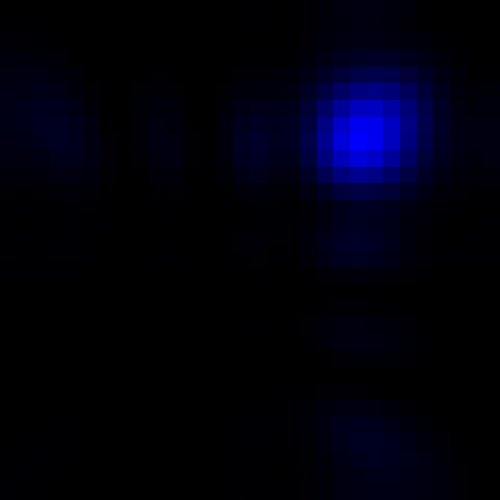

In [44]:

def show_mat(mat):
    im = PIL.Image.new(mode="RGB", size=IMAGE_DIM, color=(0, 0, 0))
    mat_abs = abs(mat)
    norm = 255 / max(mat_abs)
    for i in range(IMAGE_DIM[1]):
        for j in range(IMAGE_DIM[0]):
            val = mat_abs[i * IMAGE_DIM[1] + IMAGE_DIM[0] - j - 1] * norm
            im.putpixel((j, i), (0, 0, int(val)))
    display(im.resize((500, 500), resample=PIL.Image.Resampling.NEAREST))

show_mat(bop_1_source)

The same with 2 sources.

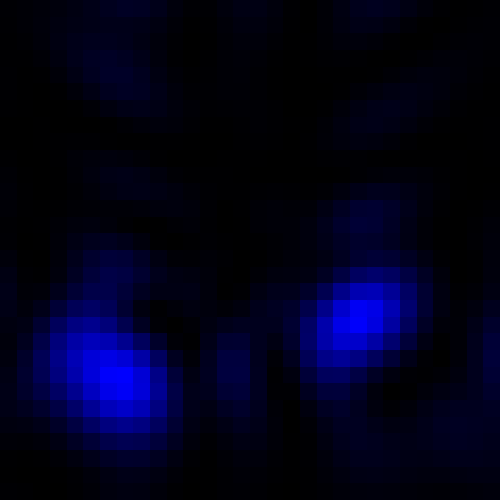

In [45]:
sources = [
    (np.array([2.0, -1.0]), hz1000),
    (np.array([-2.0, -2.0]), hz1000),
]

spectrums_2_sources = get_spectrums(sources, microphone_positions)
frequency_intensities = get_frequency_intensities(test_freq, spectrums_2_sources)
csm = get_csm(frequency_intensities)
steering_vectors = get_steering_vectors(test_points, microphone_positions, test_freq)
bop_2_sources = get_beamformer_output_power(steering_vectors, csm)

show_mat(bop_2_sources)

Now one source will produce a sound at $1KHz$ and another at $440Hz$.

Looking for $1KHz$ sound sources

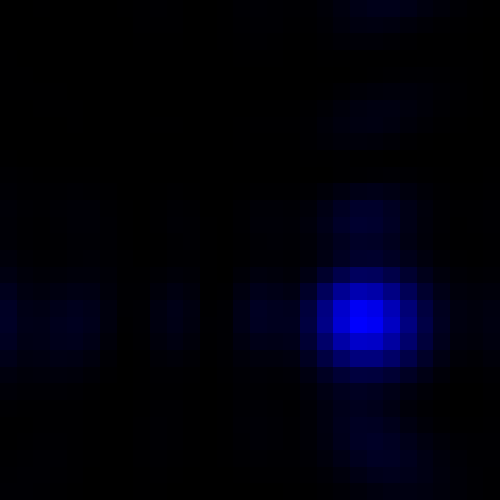

In [46]:
sources = [
    (np.array([2.0, -1.0]), hz1000),
    (np.array([-2.0, -2.0]), hz440),
]

test_freq = 1000

spectrums_2_sources = get_spectrums(sources, microphone_positions)
frequency_intensities = get_frequency_intensities(test_freq, spectrums_2_sources)
csm = get_csm(frequency_intensities)
steering_vectors = get_steering_vectors(test_points, microphone_positions, test_freq)
bop_2_sources_diff_freq = get_beamformer_output_power(steering_vectors, csm)

show_mat(bop_2_sources_diff_freq)

Looking for $440Hz$ sound sources

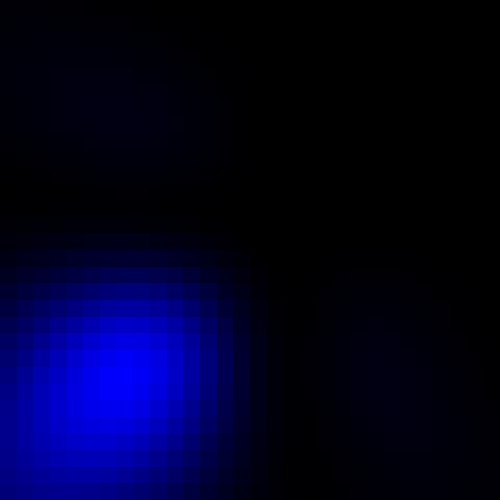

In [47]:
test_freq = 440

frequency_intensities = get_frequency_intensities(test_freq, spectrums_2_sources)
csm = get_csm(frequency_intensities)
steering_vectors = get_steering_vectors(test_points, microphone_positions, test_freq)
bop_2_sources_diff_freq = get_beamformer_output_power(steering_vectors, csm)

show_mat(bop_2_sources_diff_freq)

Now with a denser microphone array

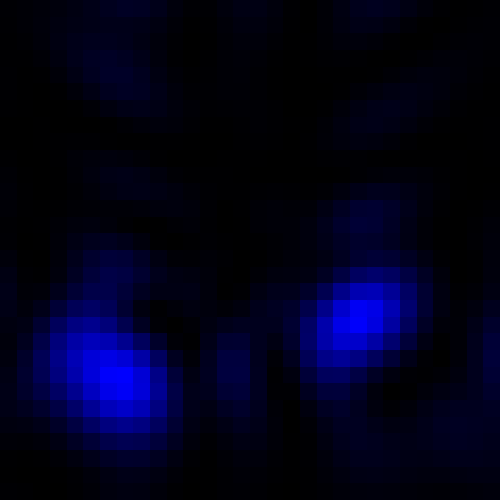

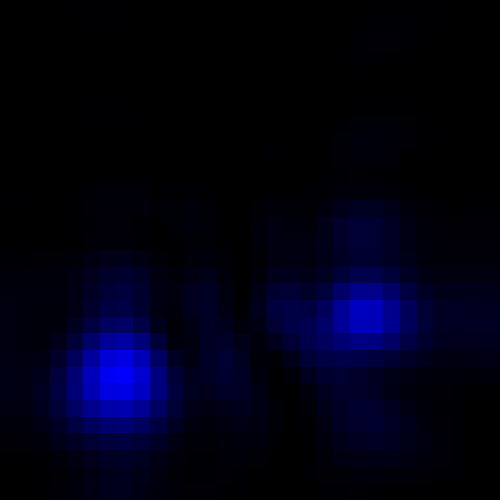

In [48]:
mic_array_dim = (11, 11)
mic_spacing = (0.15, 0.15)

microphone_positions = get_microphone_potitions(mic_array_dim, mic_spacing)

sources = [
    (np.array([2.0, -1.0]), hz1000),
    (np.array([-2.0, -2.0]), hz1000),
]

test_freq = 1000

spectrums_2_sources = get_spectrums(sources, microphone_positions)
frequency_intensities = get_frequency_intensities(test_freq, spectrums_2_sources)
csm = get_csm(frequency_intensities)
steering_vectors = get_steering_vectors(test_points, microphone_positions, test_freq)
bop_2_sources_denser = get_beamformer_output_power(steering_vectors, csm)

show_mat(bop_2_sources)
show_mat(bop_2_sources_denser)

It's evident that the spatial resolution of this technique is not great and the sources look spread out, this undesired effect is reduced by increasing the density of the microphone array.

The microphone array is acting as a spatial filter, the properties of this filter determine its point spread function, which changes the way the array respondes to a point source placed in front of it. An ideal array would respond producing an infinitesimally small point, but that device is practically impossible because it should have a spatially continuous distribution of sensors.

In real application the beamformer output is convolved with the array transfer function, producing a "dirty map".

In order to obtain better results deconvolution techniques can be used.

# Deconvolution
## DAMAS
One technique to reduce the unwanted artefacts is the Deconvolution Approach for the Mapping of Acoustic Sources (DAMAS).

In this approach we start considering the signal that a microphone $m$ placed at the center of the array would receive if a sound was produced by the source $n$ of the searching grid.

$\begin{equation} \tag {13}
P_{n:m}(\omega) = Q_n(\omega)e_{m:n}^{-1}(\omega)
\end{equation}$

The power of the signal would be written as

$\begin{equation} \tag {15}
P_{m:n}(\omega)P_{m:n}^*(\omega) =
(Q_n(\omega)e_{m:n}^{-1}(\omega))^*(Q_n(\omega)e_{m:n}^{-1}(\omega)) = 
Q_n(\omega) Q_n^*(\omega) (e_{m:n}^{-1}(\omega))^* (e_{m:n}^{-1}(\omega))
\end{equation}$

The modeled Cross Spectral Martix of the signal that the microphone would receive is

$\begin{equation} \tag {16}
CSM^{mod}_n(\omega) = X_n
\begin{bmatrix} 
(e_1^{-1})^*(e_1^{-1})           & \dots         & (e_1^{-1})^*(e_M^{-1})         \\ 
\vdots                           & \ddots        & \vdots                         \\
(e_M^{-1})^*(e_1^{-1})           & \dots         & (e_M^{-1})^*(e_M^{-1})         \\
\end{bmatrix}_n
\end{equation}$

Where $X_n$ is the power-spectral density contribution of a source located at the grid position $n$.

Considering that the the sources placed on the search grid are independent, the modeled CSM can be computed summing all the contributions of the single sources.
$\begin{equation} \tag {17}
CSM^{mod}(\omega) = \sum_{n=1}^N CSM^{mod}_n(\omega)
\end{equation}$

The modeled power output of the beamformer can now be computed as before:

$\begin{equation} \tag {18}
L^{mod}_n = \frac{\hat{e}_n^T CSM^{mod}(\omega) \hat{e}_n}{M^2} = \frac{\hat{e}_n^T \sum_{k=1}^N X_k[]_k \hat{e}_n}{M^2} = \sum_{k=1}^N \frac{\hat{e}_n^T []_k \hat{e}_n}{M^2}X_k = 
\end{equation}$

where the bracketed term is the cross inverse steering vector matrix from equation 16.


In [49]:
def get_cisvm_mods(inv_steering_vectors):
    cisvm_mods = np.conjugate(inv_steering_vectors) @ inv_steering_vectors.reshape(len(inv_steering_vectors), 1, len(microphone_positions))
    return cisvm_mods


The modeled output power of the beamformer can be further summarized as:
$\begin{equation} \tag {19}
L^{mod}_n = \sum_{k=1}^N A_{nk} X_k
\end{equation}$

where

$\begin{equation} \tag {20}
A_{nk} = \frac{\hat{e}_n^T []_k \hat{e}_n}{M^2}
\end{equation}$


In [50]:
def get_A_mat(steering_vectors):
    inv_steering_vectors = np.reciprocal(steering_vectors)
    mat = np.zeros((len(steering_vectors), len(steering_vectors)), dtype=np.complex_)
    cisvm_mods = get_cisvm_mods(inv_steering_vectors)
    for i, steering_vector in enumerate(progressbar(steering_vectors)):
        for j, csvm_mod in enumerate(cisvm_mods):
            mat[i, j] = np.take(hermite(steering_vector) @ csvm_mod @ steering_vector, 0) / len(csvm_mod)**2
    return mat


We can now equate the modeled output power with the one obtained from measured data getting a system of linear equations:
$\begin{equation} \tag {21}
\hat{Y} = \hat{A}\hat{X}
\end{equation}$

where

$\begin{equation} \tag {22}
\hat{Y} =
\left(
    \begin{aligned}
      & L_1 \\
      & L_2 \\
      & \;\;\vdots \notag \\
      & L_N
    \end{aligned}
  \right)
\end{equation}$

$\begin{equation} \tag {23}
\hat{A} =
\begin{bmatrix} 
A_{11}           & \dots         & A_{1N}         \\ 
\vdots           & \ddots        & \vdots         \\
A_{N1}           & \dots         & A_{NN}         \\
\end{bmatrix}
\end{equation}$

$\begin{equation} \tag {24}
\hat{X} =
\left(
    \begin{aligned}
      & X_1 \\
      & X_2 \\
      & \;\;\vdots \notag \\
      & X_N
    \end{aligned}
  \right)
\end{equation}$

The $\hat{A}$ matrix is usually singular, so it can't be inverted. The system of equations can be solved using an iterative method.

A single equation of the system can be written in the form
$\begin{equation} \tag {25}
A_{n1}X_1 + \dots + A_{nk}A_k + \dots + A_{nN}X_N = Y_n
\end{equation}$

The term $A_{nn}$ is equal to

$\begin{equation} \tag {26}
A_{nn} = \frac{
\hat{e}_n^T
\begin{bmatrix} 
  (e_1^{-1})^*(e_1^{-1})           & \dots         & (e_1^{-1})^*(e_M^{-1})         \\ 
  \vdots                           & \ddots        & \vdots                         \\
  (e_M^{-1})^*(e_1^{-1})           & \dots         & (e_M^{-1})^*(e_M^{-1})         \\
\end{bmatrix}_n
\hat{e}_n
}{M^2} = 1
\end{equation}$

so the equation can be rewritten as:

$\begin{equation} \tag {27}
X_n = Y_n - \left[ \sum_{k=1}^{n-1} A_{nk}X_k + \sum_{k=n+1}^N A_{nk}X_k \right]
\end{equation}$

The system of equation can now be solved iterating these steps:

$\begin{equation}  \tag {28}
X_1^{(i)} = Y_1 - \left[ 0 + \sum_{k=1+1}^N A_{1k}X_k^{(i-1)} \right]
\end{equation}$

$\begin{equation} \tag {29}
X_n^{(i)} = Y_n - \left[ \sum_{k=1}^{n-1} A_{nk}X_k^{(i)} + \sum_{k=n+1}^N A_{nk}X_k^{(i - 1)} \right]
\end{equation}$

$\begin{equation} \tag {30}
X_N^{(i)} = Y_N - \left[ \sum_{k=1}^{N-1} A_{Nk}X_k^{(i)} + 0 \right]
\end{equation}$

The componentes of $\hat{X}$ are initialized to $0$ and since the strength sound sources is non-negative, the minimim of each component is clamped to $0$. An iteration consists in the computation of $X_i$ following first the order $1 \dots N$ and then $N \dots 1$.


In [51]:
def DAMAS_iteration(a_mat, x_mat, y_mat, n):
    sum_1 = 0
    for k in range(0, n):
        f1 = a_mat[n, k]
        f2 = x_mat[k]
        sum_1 += f1 * f2

    sum_2 = 0
    for k in range(n+1, len(x_mat)):
        f1 = a_mat[n, k]
        f2 = x_mat[k]
        sum_2 += f1 * f2
    x_mat[n] = max(y_mat[n] - (np.take(sum_1, 0) + np.take(sum_2, 0)), 0)


def DAMAS(beamformer_output_power, steering_vectors, a_mat, n_iterations):
    x_mat = np.zeros((len(steering_vectors)), dtype=np.complex_)
    for _ in progressbar(range(n_iterations)):
        for n in range(len(x_mat)):
            DAMAS_iteration(a_mat, x_mat, beamformer_output_power, n)
        for n in range(len(x_mat) - 1, -1, -1):
            DAMAS_iteration(a_mat, x_mat, beamformer_output_power, n)
    return x_mat


This is the result of the DAMAS algorithm with 10 and 50 iterations

  0% (0 of 900) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  2% (23 of 900) |                       | Elapsed Time: 0:00:00 ETA:   0:00:02
  5% (46 of 900) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02
  7% (69 of 900) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02
 10% (92 of 900) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 12% (114 of 900) |##                    | Elapsed Time: 0:00:00 ETA:   0:00:02
 15% (137 of 900) |###                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 17% (160 of 900) |###                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 20% (183 of 900) |####                  | Elapsed Time: 0:00:00 ETA:   0:00:01
 22% (206 of 900) |#####                 | Elapsed Time: 0:00:00 ETA:   0:00:01
 25% (228 of 900) |#####                 | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (251 of 900) |######                | Elapsed Time: 0:00:00 ETA:   0:00:01
 30% (274 of 900) |######               

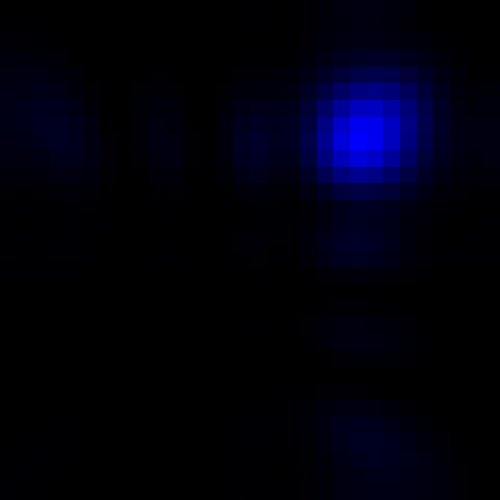

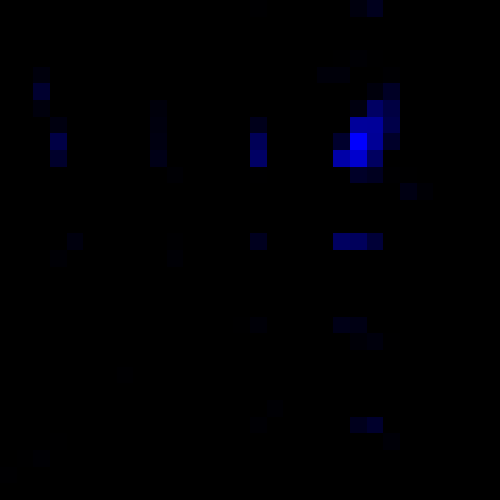

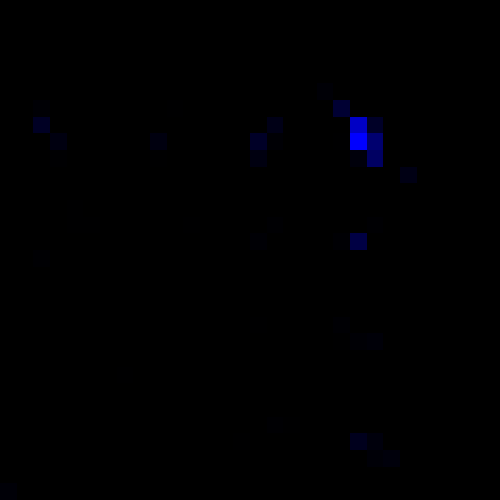

In [52]:
mic_array_dim = (5, 5)
mic_spacing = (0.3, 0.3)

microphone_positions = get_microphone_potitions(mic_array_dim, mic_spacing)

sources = [
    (np.array([2.0, 2.0]), hz1000)
]

test_freq = 1000

spectrums_1_source = get_spectrums(sources, microphone_positions)
frequency_intensities = get_frequency_intensities(test_freq, spectrums_1_source)
csm = get_csm(frequency_intensities)
steering_vectors = get_steering_vectors(test_points, microphone_positions, test_freq)
bop_1_source = get_beamformer_output_power(steering_vectors, csm)

a_mat = get_A_mat(steering_vectors)

deconvoluted_10 = DAMAS(bop_1_source, steering_vectors, a_mat, 5)
deconvoluted_20 = DAMAS(bop_1_source, steering_vectors, a_mat, 50)
show_mat(bop_1_source)
show_mat(deconvoluted_10)
show_mat(deconvoluted_20)


This is the result of the DAMAS algorithm with 100 iterations on 2 sources

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:22
  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:22
  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:21
  4% (4 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:21
  5% (5 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:21
  6% (6 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:21
  7% (7 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:21
  8% (8 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:20
  9% (9 of 100) |##                      | Elapsed Time: 0:00:02 ETA:   0:00:20
 10% (10 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:20
 11% (11 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:20
 12% (12 of 100) |##                    

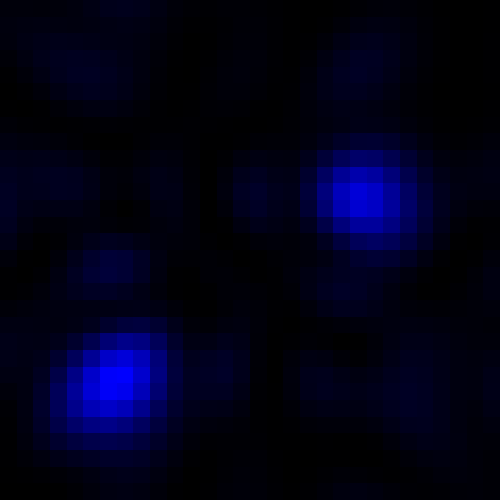

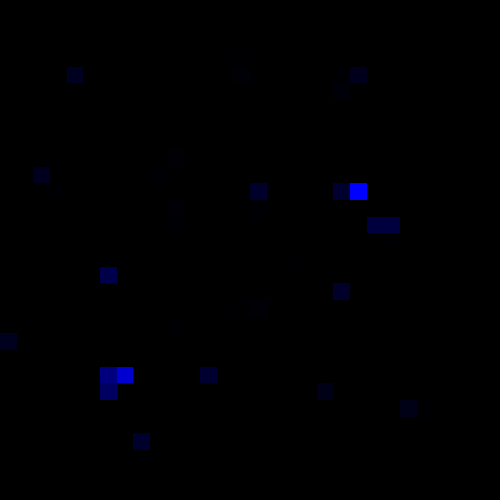

In [53]:
mic_array_dim = (5, 5)
mic_spacing = (0.3, 0.3)

microphone_positions = get_microphone_potitions(mic_array_dim, mic_spacing)

sources = [
    (np.array([2.0, 1.0]), hz1000),
    (np.array([-2.0, -2.0]), hz1000)
]

test_freq = 1000

spectrums_2_sources = get_spectrums(sources, microphone_positions)
frequency_intensities = get_frequency_intensities(test_freq, spectrums_2_sources)
csm = get_csm(frequency_intensities)
steering_vectors = get_steering_vectors(test_points, microphone_positions, test_freq)
bop_2_sources = get_beamformer_output_power(steering_vectors, csm)


deconvoluted = DAMAS(bop_2_sources, steering_vectors, a_mat, 100)
show_mat(bop_2_sources)
show_mat(deconvoluted)
